<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Understanding the Dataset

In [83]:
#Importing necesseray libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error

import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
# Set the Seaborn style for all plots
sns.set_style("darkgrid")

In [88]:
# Load preprocessed data
df = pd.read_csv('/content/bitcoin_analysis_engineered.csv', index_col='Date', parse_dates=True)

# Display the first few rows of the data
df.head()

,Open,High,Low,Close,Volume,Market Cap,Coin,Year,Month,Day,Quarter,Weekday,Daily_Return,Log_Return,EMA_7,EMA_30,RSI_14,MA_20,Upper_BB,Lower_BB
Date,,,,,,,,,,,,,,,,,,,,
2014-10-06,320.389008,345.134003,302.559998,330.079010,79011800,6.542676e+09,Bitcoin,2014,10,6,4,0,0.029856,0.029419,349.294184,398.996478,30.138935,389.910399,461.027732,318.793066
2014-10-07,330.584015,339.247009,320.481995,336.187012,49199900,6.663746e+09,Bitcoin,2014,10,7,4,1,0.018505,0.018336,346.017391,394.944255,17.642549,383.853049,451.334641,316.371457
2014-10-08,336.115997,354.364014,327.187988,352.940002,54736300,6.995816e+09,Bitcoin,2014,10,8,4,2,0.049832,0.048630,347.748044,392.234303,27.775351,380.278049,446.265429,314.290669
2014-10-09,352.747986,382.726013,347.687012,365.026001,83641104,7.235380e+09,Bitcoin,2014,10,9,4,3,0.034244,0.033671,352.067533,390.478929,35.319233,378.789549,444.741094,312.838004
2014-10-10,364.687012,375.066986,352.963013,361.562012,43665700,7.166718e+09,Bitcoin,2014,10,10,4,4,-0.009490,-0.009535,354.441153,388.613321,36.159745,376.422450,441.211135,311.633765


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3779 entries, 2014-10-06 to 2025-02-08
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3779 non-null   float64
 1   High          3779 non-null   float64
 2   Low           3779 non-null   float64
 3   Close         3779 non-null   float64
 4   Volume        3779 non-null   int64  
 5   Market Cap    3779 non-null   float64
 6   Coin          3779 non-null   object 
 7   Year          3779 non-null   int64  
 8   Month         3779 non-null   int64  
 9   Day           3779 non-null   int64  
 10  Quarter       3779 non-null   int64  
 11  Weekday       3779 non-null   int64  
 12  Daily_Return  3779 non-null   float64
 13  Log_Return    3779 non-null   float64
 14  EMA_7         3779 non-null   float64
 15  EMA_30        3779 non-null   float64
 16  RSI_14        3779 non-null   float64
 17  MA_20         3779 non-null   float64
 18  Upper_BB  

## 2. Data Preprocessing

In [90]:
# Select only the 'Close' price
df_close = df[['Close']]

In [91]:
df_close.head()

,Close
Date,
2014-10-06,330.079010
2014-10-07,336.187012
2014-10-08,352.940002
2014-10-09,365.026001
2014-10-10,361.562012


## Train Test Split

In [92]:
# Determine the split index for 80% training and 20% testing
split_index = int(len(df_close) * 0.8)

# Training Data: First 80% of the dataset
df_train = df_close[:split_index].values

# Test Data: Last 20% of the dataset
df_test = df_close[split_index:].values

In [93]:
df_train.shape

(3023, 1)

In [94]:
df_test.shape

(756, 1)

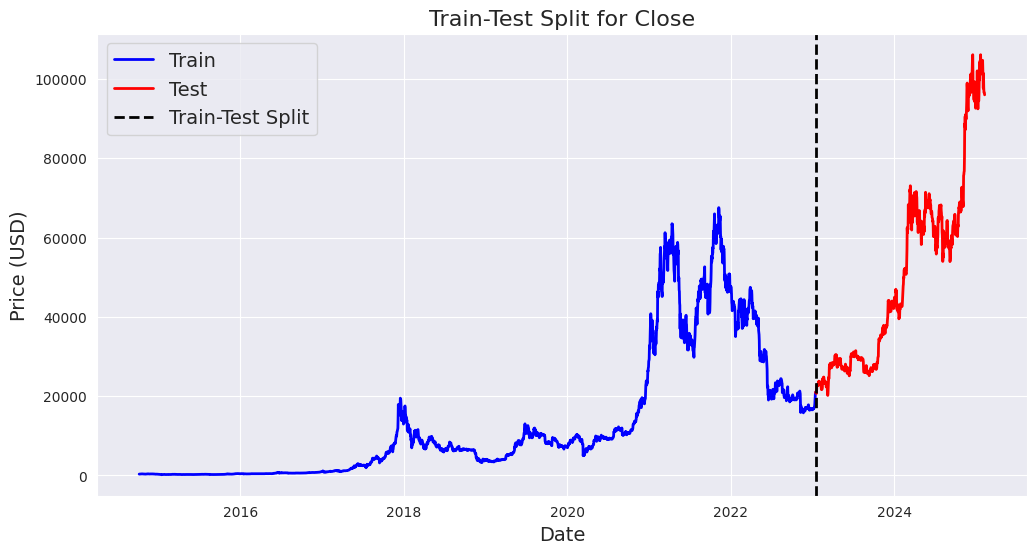

In [95]:
# Define the column to plot
chosen_col = 'Close'

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot training data
ax.plot(df.index[:split_index], df_train, label='Train', linewidth=2, color='blue')

# Plot test data
ax.plot(df.index[split_index:], df_test, label='Test', linewidth=2, color='red')

# Labels and title
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Price (USD)', fontsize=14)
ax.set_title(f'Train-Test Split for {chosen_col}', fontsize=16)

# Add vertical split line
ax.axvline(df.index[split_index], color='black', linestyle='--', linewidth=2, label='Train-Test Split')

# Show legend
ax.legend(loc='best', fontsize=14)

# Show plot
plt.show()

### Feature Scaling

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Min Max Scaling of Data post Train-Test Split </h3>
</div>

I ensured that scaling is done only after splitting the data into training and test sets, with each set being scaled separately.

Performing normalization on the data before splitting it is problematic because the scaling process would use the entire dataset — including the test set — as a reference.

This inadvertently causes data leakage from the test set into the training data, leading to unrealistic model performance and potential overfitting. By scaling only after the split, I ensured that the test set remained unseen and untouched during training, which is crucial for accurate model evaluation.










In [96]:
# Initialize a single MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on training data and transform both train and test
scaled_train = scaler.fit_transform(df_train.reshape(-1, 1))  # Fit & transform train
scaled_test = scaler.transform(df_test.reshape(-1, 1))  # Transform test only (no fit)

# Print shapes for confirmation
print(f"Scaled Train Shape: {scaled_train.shape}")
print(f"Scaled Test Shape: {scaled_test.shape}")

Scaled Train Shape: (3023, 1)
Scaled Test Shape: (756, 1)


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Time Series Windowing (Sequence Generation) </h3>
</div>

Since I’m working with **time series data**, I need the LSTM model to learn from **sequential patterns** instead of treating each data point independently.  

Time series windowing transforms raw time series data into **input-output pairs** so that the model can learn from historical data and make accurate future predictions.  

---

**Steps I Took**  

**1️⃣ Defined a Look-Back Window (Sliding Window)**  
I set a **look-back period** (`look_back = 5`), meaning the model will use the **past 5 days' prices** to predict the **next day's price**.  
This helps capture short-term trends in the data.

 Example:  


For example, given a sequence like [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], the data will be split into samples like:

```python

Input 				| Output
1, 2, 3, 4, 5 		6
2, 3, 4, 5, 6 		7
3, 4, 5, 6, 7 		8

```
**2️⃣ Created Input (X) and Output (y) Pairs**  
I looped through the **scaled dataset** and extracted:  
- **X** → The past `look_back` days (input sequence).  
- **y** → The next day's value (target label).  



In [97]:
def create_sequences(dataset, look_back=5):
    """
    Generates input-output pairs for LSTM.

    Args:
        dataset (numpy.ndarray): Scaled dataset.
        look_back (int): Number of previous timesteps used for prediction.

    Returns:
        X: Input sequences (features).
        y: Target values (labels).
    """
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])  # Past `look_back` values
        y.append(dataset[i + look_back, 0])  # The next value (target)
    return np.array(X), np.array(y)

# Define look_back period (e.g., 5 days)
look_back = 5

# Generate sequences
trainX, trainY = create_sequences(scaled_train, look_back)
testX, testY = create_sequences(scaled_test, look_back)

### Reshaping Data (LSTM Format)

- Convert trainX & testX into (samples, time steps, features) format for LSTM.
- **Samples**: The total number of data points (`len(dataX)`).
- **Time steps**: The width of the sliding window (e.g., 5 in this case).
- **Features**: The number of features per time step. For example, in predicting Bitcoin price, the feature is 1 (the price at that time step).
- LSTM expects 3D inputs.

In [98]:
# Reshape to (samples, time steps, features)
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

# Print shapes to verify correctness
print("trainX shape:", trainX.shape)  # (samples, look_back, 1)
print("trainY shape:", trainY.shape)  # (samples,)
print("testX shape:", testX.shape)    # (samples, look_back, 1)
print("testY shape:", testY.shape)    # (samples,)

trainX shape: (3018, 5, 1)
trainY shape: (3018,)
testX shape: (751, 5, 1)
testY shape: (751,)


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LSTM (Long Short-Term Memory) Mechanism </h3>
</div>

LSTM is a type of recurrent neural network (RNN) designed to overcome the vanishing gradient problem. It uses internal gates to regulate information flow, enabling effective backpropagation through time (BPTT).

#### LSTM Layers in Keras
- LSTM layers can be created using the `LSTM()` class in Keras.
- Each LSTM cell has an internal **cell state** (`c`) and a **hidden state** (`h`).
- The `input_shape` for LSTM is `(timesteps, n_features)`, e.g., `(95000, 360)`.
- Keras LSTM expects inputs in the shape: `(n_examples, n_timesteps, n_features)`.

#### `return_sequences=True`
- Enables stacking of multiple LSTM layers.
- Ensures the second LSTM layer receives a compatible n-dimensional sequence input.
- Outputs one value per time step when set to `True`.

#### Why Increase LSTM Depth?
- **Enhances feature abstraction**: Similar to deep learning, deeper LSTMs recombine learned representations to capture complex patterns.
- **Efficient training**: Deeper networks often require fewer neurons and train faster.
- **Temporal abstraction**: Stacking LSTM layers allows models to process sequences at different time scales.

Stacked LSTMs have become a standard approach for complex sequence prediction tasks.


In [99]:
# Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Build an improved LSTM model
model = Sequential([
    LSTM(units=40, return_sequences=True, activation='tanh',
         kernel_regularizer=l2(0.001), input_shape=(trainX.shape[1], 1)),
    Dropout(0.3),  # Increased dropout

    LSTM(units=30, return_sequences=False, activation='tanh',
         kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(units=20, activation='relu'),
    Dense(units=1)  # Output layer (linear activation for regression)
])

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train the model with early stopping and a larger batch size
history = model.fit(
    trainX, trainY,
    epochs=100,
    batch_size=64,  # Increased batch size
    validation_data=(testX, testY),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1233 - val_loss: 0.1120
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0551 - val_loss: 0.0369
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0366 - val_loss: 0.0330
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0277 - val_loss: 0.0219
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0213 - val_loss: 0.0171
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - val_loss: 0.0136
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0129 - val_loss: 0.0113
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0104 - val_loss: 0.0115
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0084
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056 - v

## Model Evaluation

### Evaluate Model on Test Data

In [100]:
# Evaluate model performance on test data
test_loss = model.evaluate(testX, testY, verbose=1)
print(f"Test Loss (MSE): {test_loss:.6f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Test Loss (MSE): 0.002322


### Plot Training & Validation Loss Curves

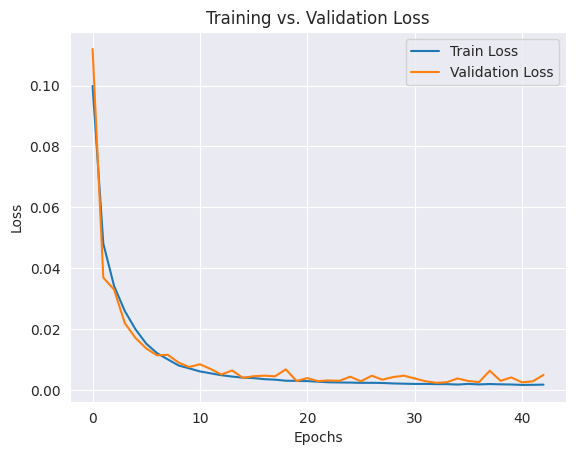

In [101]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

### Generate Predictions & Inverse Transform

In [102]:
# Predict using the model
predicted = model.predict(testX)

# Inverse transform predictions if data was scaled
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(testY.reshape(-1, 1))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


### Performance Metrics (RMSE & MAE)

In [103]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Root Mean Squared Error (RMSE): 2777.5276
Mean Absolute Error (MAE): 2108.5850


### Plot Actual vs. Predicted Values

In [106]:
df['Date'] = df.index

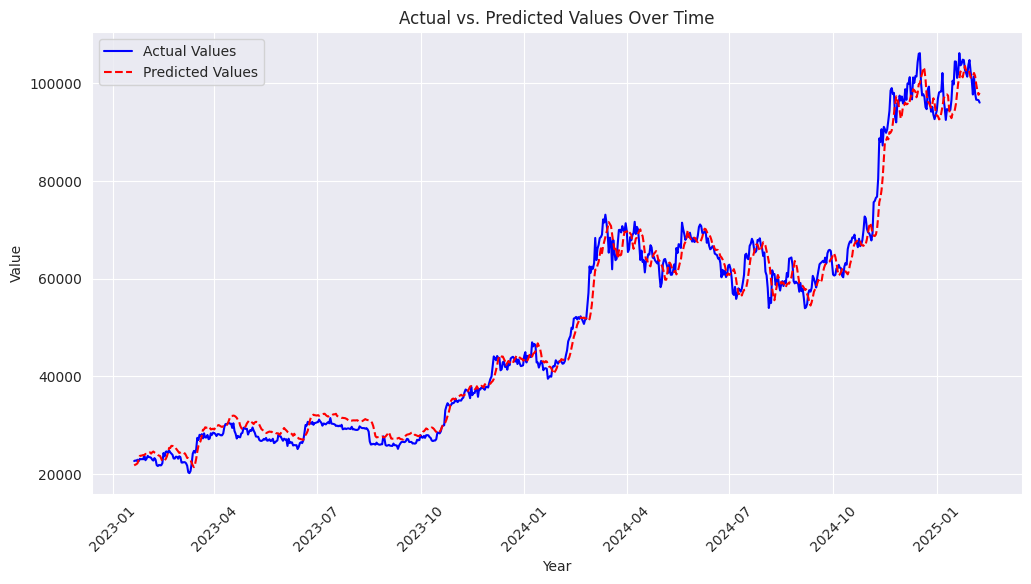

In [107]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(actual):], actual, label="Actual Values", color='blue', linestyle='solid')
plt.plot(df['Date'][-len(predicted):], predicted, label="Predicted Values", color='red', linestyle='dashed')

# Graph labels
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Actual vs. Predicted Values Over Time")
plt.legend()
plt.xticks(rotation=45)  # Rotate for better visibility
plt.show()